In [1]:
] activate ../../Acceleration

 Activating environment at `~/Desktop/Code/Acceleration/Acceleration/Project.toml`


In [2]:
using Acceleration
using LinearAlgebra

n = 1000; # number of samples
d = 100;    # number of features
selected_labels = [0,1];  ## Only two labels allowed

data, labels = load_dataset("MNIST",[0,1],n,d);
f,∇f,∇ϕ_cjg,σ,L,μ  = linear_regression(data,labels);

┌ Info: Loading dataset MNIST with 60000 samples and 784 features
└ @ Acceleration /Users/victor/Desktop/Code/Acceleration/Acceleration/src/datasets.jl:26


In [3]:
n = size(data,2)
x_ini = zeros(n)


using JuMP
using Ipopt

@time model = Model(with_optimizer(Ipopt.Optimizer))
@time set_silent(model)
@time @variable(model, x[1:n])
@time @objective(model, Min, f(x))
@time optimize!(model)
@time x_opt = value.(x);

  0.554161 seconds (651.26 k allocations: 33.561 MiB, 2.81% gc time)
  0.051704 seconds (168.98 k allocations: 8.341 MiB)
  0.651721 seconds (1.68 M allocations: 81.729 MiB, 4.38% gc time)
  1.130997 seconds (2.59 M allocations: 347.892 MiB, 4.87% gc time)

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 16.503947 seconds (85.87 M allocations: 4.953 GiB, 7.07% gc time)
  0.182222 seconds (488.99 k allocations: 25.483 MiB)


In [13]:
n = length(x_ini)
x = x_ini;
y = zeros(n);
z = zeros(n);
v = zeros(n);
A = 1;
AX = zeros(n);

k = 11;
aks = zeros(k);
R = zeros(k);
xks = zeros(n,k);
axks = zeros(n,k);
yks = zeros(n,k);
zks = zeros(n,k);
up = zeros(k);
#μ = 0;
s = zeros(n);
noise = 0;



function varphi_k_cjg(k,z,μ,aks,xks)
    A = sum(aks[1:k])
    AX = sum(axks[:,1:k], dims=2)
    v = (z + μ*AX)*inv(μ*A);
    return z'*x - (1/2)*norm(v,2)^2 - (μ/2)
end

for i=1:k   
   
    a = L; b = -(μ*A + σ); c = -μ*A^2 - σ*A;
    α = (-b + sqrt(b^2 - 4*a*c)) / (2*a);
    #α = (σ/L) * (i+1)/2
    A = A + α;
    x = (A-α)/A*y + α/A*v; 
    AX = AX + α*x;

    η = zeros(n)
    approx_gradient = ∇f(x)+η;
    
    s = s + α*η;
    z = z - α*approx_gradient;
    
    v_past = v;
    v = (z + μ*AX)*inv(μ*(A-1));
    y = (A-α)*inv(A)*y + α*inv(A)*v; 
    y2 = x - (1/L)*approx_gradient    
    
    aks[i] = α;
    xks[:,i] = x;
    axks[:,i] = α*x;
    yks[:,i] = y;
    zks[:,i] = z;
    
    a1 = varphi_k_cjg(i,z,μ,aks,xks)
    a2 = varphi_k_cjg(i-1,z+α*approx_gradient,μ,aks,xks)
    a3 = -varphi_k_cjg(i,z+α*approx_gradient,μ,aks,xks)
    a4 = -varphi_k_cjg(i-1,z,μ,aks,xks)
    
    #R[i] = (a1 + a2 + a3 + a4) / norm(α*∇f(x))
    #R[i] = (a1 + a2 + a3 + a4) / α
    R[i] = (a1+a)
    
    println(a1+a4)
#    println(a4)
    #println(R[i])
    #println(norm(z))
    #println(norm(v-v_past) - 4/(μ*A + σ)*norm(α*∇f(x)))

end

x_out = yks;


Inf
2.7997801356827334e7
8.44699757545094e9
2.671812792251305e12
6.363771896445299e14
1.1260215947260842e17
1.5159066957224534e19
1.5926806994179997e21
1.3354684077306338e23
9.109104907434413e24
5.1369201967231685e26


In [261]:
a1

LoadError: UndefVarError: a1 not defined

7.933172339363267

In [245]:
A = sum(aks[1:k])
#AX = sum(axks[:,1:k], dims=2)

0.026135011465306085

4.416140701251106
0.0
0.0


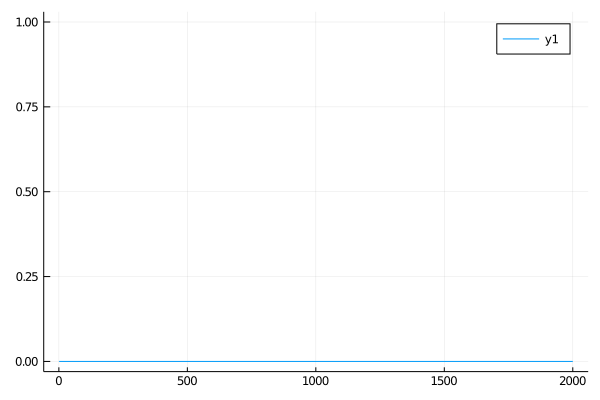

In [224]:
println(μ)
println(maximum(R))
println(minimum(R))
plot(R)

In [204]:
α

2.6002680535014518e70

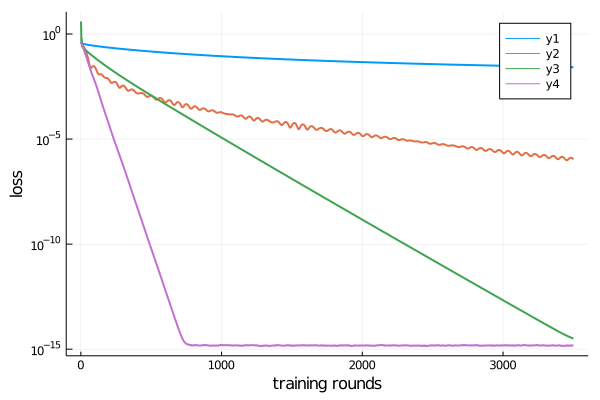

In [205]:
using Plots
using LinearAlgebra

p_out = sqrt.(sum((x_out .- x_opt).^2, dims=1)');
p_gd = sqrt.(sum((x_gd .- x_opt).^2, dims=1)');
p_amd = sqrt.(sum((x_amd .- x_opt).^2, dims=1)');
p_amd2 = sqrt.(sum((x_amd2 .- x_opt).^2, dims=1)');

plot(max.(hcat(p_gd,p_amd,p_amd2,p_out),1e-20),yaxis=:log,linewidth=2,xlabel="training rounds",ylabel="loss")

In [99]:
sum(axks[:,1:3], dims=2)

100×1 Array{Float64,2}:
 -0.011718285848630081
 -0.0009469935170420711
 -0.0005838917558415271
  0.0010745390763980526
  0.0029307079451174043
  0.00030021489886469327
 -0.0020324849310213015
  0.0015298448189158952
  0.0002120237153614796
  0.0005063753467939593
 -0.000788858674593201
 -5.935508274186361e-5
 -8.22100890420086e-5
  ⋮
 -4.224883910628286e-6
 -3.894369878219405e-5
  5.52862578470693e-5
 -2.190350900153846e-5
 -1.9900956152342438e-5
  4.942215989982743e-5
 -1.6638033845824105e-5
  6.278729669425337e-5
 -3.1347269734339306e-5
  4.04559679403237e-5
  9.622170280114313e-5
 -0.00010361362263109215